# Continuous Control

---

In this notebook, D3PG agent will be implemented and tested on the Reacher Unity Environment for the second project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
import numpy as np

# select this option to load version 2 (with 20 agents) of the environment
env = UnityEnvironment(file_name='C:\\Users\\anindex\\Desktop\\Reacher_Windows_x86_64_20\\Reacher_Windows_x86_64\\Reacher.exe')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


In [2]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [3]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 20
Size of each action: 4
There are 20 agents. Each observes a state with length: 33
The state for the first agent looks like: [ 0.00000000e+00 -4.00000000e+00  0.00000000e+00  1.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.00000000e+01  0.00000000e+00
  1.00000000e+00 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  5.75471878e+00 -1.00000000e+00
  5.55726624e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
 -1.68164849e-01]


### 3. Training DDPG agent

The implementation for DDPG agent is imported from this repository subfolder `agents/` as a library. 

In [4]:
import sys
import os
import torch
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

#uncomment the following line if import failed
sys.path.insert(0, os.path.abspath(os.path.join(os.path.dirname(__name__), '..')))
from agents.agents import DDPGAgent

agent = DDPGAgent(state_size, action_size, random_seed=0, num_agents=num_agents)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
       BatchNorm1d-1                   [-1, 33]              66
            Linear-2                  [-1, 256]           8,704
       BatchNorm1d-3                  [-1, 256]             512
            Linear-4                  [-1, 128]          32,896
       BatchNorm1d-5                  [-1, 128]             256
            Linear-6                    [-1, 4]             516
Total params: 42,950
Trainable params: 42,950
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.16
Estimated Total Size (MB): 0.17
----------------------------------------------------------------
MAFCPolicy(
  (bn_input): BatchNorm1d(33, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=33, out_features=256, bias=True)
  (bn

In [ ]:
# loading checkpoint if the file exists

if os.path.isfile('actor.pth') and os.path.isfile('critic.pth'):
    agent.actor_local.load_state_dict(torch.load('actor.pth'))
    agent.actor_target.load_state_dict(torch.load('actor.pth'))
    agent.critic_local.load_state_dict(torch.load('critic.pth'))
    agent.critic_target.load_state_dict(torch.load('critic.pth'))
    print("Loaded previous trained DDPG agent!")

In [ ]:
from workspace_utils import active_session

def train_ddpg(n_episodes=2000, max_t=1000, start_episode=1, print_every=100, save_every=500, saving=False, eps = 1.0, eps_linear_decay=1e-5, eps_min=0.1):
    """Distributional DDPG (D3PG)
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
    """
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    
    saved = False

    for i_episode in range(start_episode, start_episode+n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]
        agent.reset()
        
        states = env_info.vector_observations
        current_scores = np.zeros(num_agents)
        for t in range(max_t):
            actions = agent.act(states, eps)
            env_info = env.step(actions)[brain_name]
            
            next_states = env_info.vector_observations  
            rewards = env_info.rewards                
            dones = env_info.local_done
            current_scores += env_info.rewards
            
            for i in range(num_agents):
                agent.step(states[i], actions[i], rewards[i], next_states[i], dones[i])
                
            states = next_states
            eps = max(eps_min, eps - eps_linear_decay)
            if np.any(dones):
                break 
            
        avg_score = np.mean(current_scores)
        scores_window.append(avg_score)       # save most recent score
        scores.append(avg_score)              # save most recent score

        mean_score = np.mean(scores_window)
        if i_episode % print_every == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}\tScore: {:.2f}'.format(i_episode, mean_score, avg_score))
        if mean_score >= 30.0 and saving and not saved:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}, saving models!'.format(i_episode, mean_score))
            torch.save(agent.actor_local.state_dict(), 'actor.pth')
            torch.save(agent.critic_local.state_dict(), 'critic.pth')
            saved = True
    return scores

with active_session():
    scores = train_ddpg(n_episodes=200, print_every=10, saving=True)

Episode 10	Average Score: 1.10	Score: 1.52
Episode 20	Average Score: 1.48	Score: 1.65
Episode 30	Average Score: 1.77	Score: 2.50
Episode 40	Average Score: 2.49	Score: 5.89
Episode 50	Average Score: 3.51	Score: 8.68
Episode 60	Average Score: 4.73	Score: 15.25
Episode 70	Average Score: 6.41	Score: 17.64
Episode 80	Average Score: 8.21	Score: 22.02
Episode 90	Average Score: 10.31	Score: 28.55
Episode 100	Average Score: 12.28	Score: 30.69
Episode 110	Average Score: 15.37	Score: 34.02
Episode 120	Average Score: 18.72	Score: 35.35
Episode 130	Average Score: 22.09	Score: 37.43


In [ ]:
# run this cell for saving scores and Q network state_dict

import pickle

with open('DDPG_control_scores', 'wb') as fp:
    pickle.dump(scores, fp)
    
torch.save(agent.actor_local.state_dict(), 'actor.pth')
torch.save(agent.critic_local.state_dict(), 'critic.pth')

Unfortunately, although my models were successfully saved, somehow the output of the training cell did not record the success message and even the recorded training score is lost when the GPU time run out (it costs me 35 hours to train this model!). I am not sure what cause this, so I have included a testing function (no training) with rewards of 20 agents averaged over 100 episodes. 

### 4. Evaluate the agent

We will then observe the trained behavior of the DDPG agent ands finally record the total average score of 20 agents. The next cell will load the saved model and then we can test the model on the env.

In [5]:
agent = DDPGAgent(state_size, action_size, random_seed=0, num_agents=num_agents)

if os.path.isfile('actor.pth') and os.path.isfile('critic.pth'):
    agent.actor_local.load_state_dict(torch.load('actor.pth'))
    agent.critic_local.load_state_dict(torch.load('critic.pth'))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
       BatchNorm1d-1                   [-1, 33]              66
            Linear-2                  [-1, 256]           8,704
       BatchNorm1d-3                  [-1, 256]             512
            Linear-4                  [-1, 128]          32,896
       BatchNorm1d-5                  [-1, 128]             256
            Linear-6                    [-1, 4]             516
Total params: 42,950
Trainable params: 42,950
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.16
Estimated Total Size (MB): 0.17
----------------------------------------------------------------
MAFCPolicy(
  (bn_input): BatchNorm1d(33, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=33, out_features=256, bias=True)
  (bn

In [9]:
def test_ddpg(n_episodes=2000, max_t=1000, start_episode=1, print_every=100):
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    
    for i_episode in range(start_episode, start_episode+n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]
        agent.reset()
        
        states = env_info.vector_observations
        current_scores = np.zeros(num_agents)
        for t in range(max_t):
            actions = agent.act(states)                        # select an action (for each agent)

            env_info = env.step(actions)[brain_name]           # send all actions to tne environment
            next_states = env_info.vector_observations         # get next state (for each agent)
            rewards = env_info.rewards                         # get reward (for each agent)
            dones = env_info.local_done                        # see if episode finished
            current_scores += env_info.rewards                         # update the score (for each agent)
            states = next_states                               # roll over states to next time step
            if np.any(dones):                                  # exit loop if episode finished
                break
        avg_score = np.mean(current_scores)
        scores_window.append(avg_score)       # save most recent score
        scores.append(avg_score)              # save most recent score
        mean_score = np.mean(scores_window)
        if i_episode % print_every == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}\tScore: {:.2f}'.format(i_episode, mean_score, avg_score))
    return scores

scores = test_ddpg(n_episodes=200)

Episode 100	Average Score: 37.80	Score: 38.32
Episode 200	Average Score: 37.87	Score: 38.16


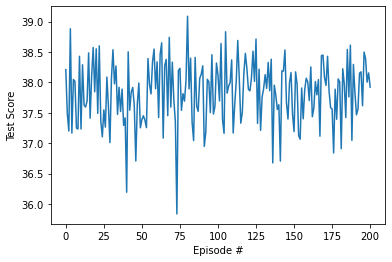

In [10]:
# plot the test scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Test Score')
plt.xlabel('Episode #')
plt.show()

As can be seen, the agent is successfully trained and is able to maintain mean testing score of 37.8 over 100 episodes! Now we can enjoy watching our trained agent reaching the green objects.

In [7]:
env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
states = env_info.vector_observations                  # get the current state (for each agent)
scores = np.zeros(num_agents)                          # initialize the score (for each agent)
while True:
    actions = agent.act(states)                        # select an action (for each agent)

    env_info = env.step(actions)[brain_name]           # send all actions to tne environment
    next_states = env_info.vector_observations         # get next state (for each agent)
    rewards = env_info.rewards                         # get reward (for each agent)
    dones = env_info.local_done                        # see if episode finished
    scores += env_info.rewards                         # update the score (for each agent)
    states = next_states                               # roll over states to next time step
    if np.any(dones):                                  # exit loop if episode finished
        break
print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

Total score (averaged over agents) this episode: 37.38499916438013


In [11]:
env.close()